# <p style='color: #87CEEB; text-align: center'>Q-Learning Trading Agent</p>

## <p style='color: #F88379;'>Objectif</p>

Former un agent de trading tabulaire (Q-Learning) sur le titre Apple
à partir de données historiques déjà normalisées, puis évaluer ses
performances sur un jeu de test hors-échantillon.

## <p style='color: #F88379;'>Structure du script</p>

1. Imports et configuration
2. Préparation / enrichissement des données
3. Définition de l’environnement `TradingEnvironment`
4. Implémentation de l’agent `Q-Learning Agent`
5. Boucle d’entraînement
6. Backtest & visualisations

### <p style='color: green;'>1. Imports</p>

In [1]:
import numpy as np                 # Calcul numérique
import pandas as pd                # Manipulation de données tabulaires
import matplotlib.pyplot as plt    # Visualisation
import random                      # Générateur aléatoire basique

In [2]:
# Pour des résultats reproductibles
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


### <p style='color: green;'>2. Preparation des donnees</p>

In [3]:
# Chargement du fichier pré‑normalisé.
data = pd.read_csv('data/apple_data_normalized.csv')

# Conversion de la colonne Date au format datetime
data['Date'] = pd.to_datetime(data['Date'])

# Tri chronologique (prudence si le CSV n’est pas déjà ordonné)
data.sort_values('Date', inplace=True)
data.reset_index(drop=True, inplace=True)


In [4]:
# --------- Feature Engineering ---------
# Rendement journalier (1ère différence logarithmique, ici %)
data['Return'] = data['Adj Close'].pct_change()

- Que fait-on ?  
    pct_change() calcule la variation en pourcentage d’un jour à l’autre 

- Pourquoi ?    
    Le simple rendement quotidien est la base de nombreux indicateurs de performance et permet de standardiser les fluctuations de prix.

In [5]:
#Suivre la tendance du marché (hausse ou baisse) en lissant les prix sur une période donnée.

# Moyennes mobiles simples sur 5 et 20 jours
data['MA5']  = data['Adj Close'].rolling(window=5).mean()
data['MA20'] = data['Adj Close'].rolling(window=20).mean()

# Signal binaire : 1 si MA5 > MA20
data['MA_Signal'] = (data['MA5'] > data['MA20']).astype(int) # Moyennes mobiles simples sur 5 et 20 jours

- Que fait-on ?

    - MA5 : moyenne des 5 dernières valeurs de clôture.

    - MA20 : moyenne des 20 dernières valeurs de clôture.

    - MA_Signal : indicateur binaire valant 1 lorsque MA5 dépasse MA20 (croisement haussier), 0 sinon.

- Pourquoi ?

    - Les croisements de moyennes mobiles sont un signal de tendance :

    - MA5 > MA20 signale une dynamique à court terme plus haussière que la tendance à moyen terme.

    - C’est un indicateur simple de momentum.

In [6]:
#Indicateur technique qui mesure la force du mouvement des prix pour détecter les zones de surachat ou survente.
# RSI (Relative Strength Index) sur 14 périodes

delta = data['Adj Close'].diff()## Variation journalière
gain  = delta.clip(lower=0) # Gains uniquement
loss  = -delta.clip(upper=0)  # Pertes uniquement
avg_gain = gain.rolling(window=14).mean() # Moyenne des gains sur 14 jours
avg_loss = loss.rolling(window=14).mean()  # Moyenne des pertes sur 14 jours
rs = avg_gain / avg_loss # Force relative
data['RSI'] = 100 - (100 / (1 + rs)) # Formule du RSI
# RSI > 70 ➜ le prix pourrait baisser bientôt. 
# RSI < 30 ➜ le prix pourrait remonter bientôt.

- Que fait-on ?

    - delta : variation brute jour à jour.

    - gain (positif) et loss (négatif converti en positif).

    - Moyennes mobiles sur 14 jours de ces gains et pertes.

    - RS = ratio des gains moyens sur les pertes moyennes.

    - RSI = 100 − (100 / (1 + RS)), variant entre 0 et 100.

- Pourquoi ?

    - Le RSI mesure la force relative des hausses vs baisses sur la période choisie.

    - Valeurs typiques :

        - 70 : marché potentiellement suracheté

        - < 30 : marché potentiellement survendu

In [7]:
# Bandes de Bollinger (20 j ; ±2σ)
#Indicateur technique qui mesure la variabilité du marché et aide à détecter les zones de prix extrêmes.
rolling_mean = data['Adj Close'].rolling(window=20).mean() # Moyenne mobile 20 jours
rolling_std  = data['Adj Close'].rolling(window=20).std()  # Écart-type sur 20 jours
data['Bollinger_Upper'] = rolling_mean + 2 * rolling_std   # Bande supérieure
data['Bollinger_Lower'] = rolling_mean - 2 * rolling_std   # Bande inférieure
# Prix touche la bande haut --> Surachat possible, prix trop haut
# Prix touche la bande basse  --> Survente possible, prix trop bas
# Bandes s'écartent	--> Volatilité élevée
# Bandes se resserrent  -->	Volatilité faible

- Que fait-on ?

     Calcule la moyenne et l’écart-type sur 20 jours, puis trace deux bandes à ±2 écarts-types autour de la moyenne.

- Pourquoi ?

    -  Les prix ont tendance à revenir à la moyenne ;

    - Les bandes mesurent la volatilité :

        - Rupture au-dessus de la bande supérieure peut indiquer un excès haussier

        - Rupture en dessous de la bande inférieure peut signaler un excès baissier

In [8]:
#L'indicateur MACD est utilisé pour détecter les changements de tendance et la force d'une tendance 
# en comparant deux moyennes mobiles exponentielles (EMA) de périodes différentes.
#MACD > 0 ➜ La tendance est haussière, l'EMA courte (12 jours) est plus haute que l'EMA longue (26 jours).


# MACD : EMA12 – EMA26
exp1 = data['Adj Close'].ewm(span=12, adjust=False).mean() #calcul moyennes mobiles exponentielles
exp2 = data['Adj Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2

- Que fait-on ?

    - ewm(...).mean() calcule une moyenne mobile exponentielle :

        - EMA12 (12 jours)

        - EMA26 (26 jours)

    - MACD = EMA12 − EMA26.

-  Pourquoi ?

    -   Le MACD détecte les changements de momentum :

        - Quand MACD passe de négatif à positif, signal d’accélération haussière.

        - Inversement, un passage en zone négative signale un ralentissement.

In [9]:
#comparer le volume de transactions actuel avec le volume moyen sur une période donnée. 
# Volume normalisé (z‑score sur fenêtre 20) , on mesure combien le volume actuel s'écarte de la moyenne sur une période (ici, 20 jours), en termes d'écart-type.
data['Volume_Norm'] = (
    (data['Volume'] - data['Volume'].rolling(20).mean())
    / data['Volume'].rolling(20).std()
)

# Drop des premières lignes contenant des NaN dus aux rollings
data.dropna(inplace=True)

-  Que fait-on ?

    - Pour chaque jour, on prend la différence entre le volume et sa moyenne sur 20 jours, puis on la divise par l’écart-type :

-   Pourquoi ?

    - Mettre en évidence les pics de volume (forte activité) par rapport à la normale.

    - Un z-score élevé signale un intérêt inhabituel (achat/vente important).

In [10]:
# --------- Discrétisation du rendement ---------
# Q‑Learning tabulaire exige des états discrets ;
# ici on bucketise Return en 3 classes :
#   0  – forte baisse  (< −1 %)
#   1  – quasi neutre (|ret| ≤ 1 %)
#   2  – forte hausse (>  +1 %)
def discretize_return(ret: float) -> int:
    if ret > 0.01:
        return 2
    elif ret < -0.01:
        return 0
    else:
        return 1

data['Return_Class'] = data['Return'].apply(discretize_return)

### <p style='color: green;'>3. Envirenement de trading</p>


In [11]:
class TradingEnvironment:
    """Environnement minimaliste compatible avec l’API Gym.

    Paramètres
    ----------
    data : pd.DataFrame
        Jeu de données chronologiques contenant les features
        et le prix de référence ('Adj Close').

    Actions
    -------
    0 : Conserver (Hold)
    1 : Acheter      (Open/Keep Long)
    2 : Vendre       (Close Long)

    Remarque : seul un aller‑retour long est autorisé ; pas de short.
    """
    
    TRANSACTION_COST = 0.0005  # 0,05 % par trade (aller ou retour)

    def __init__(self, data):
        self.data = data
        self.n_steps = len(data)
        self.reset()

    def reset(self):
        """Réinitialise l’environnement à l’état initial."""
        self.current_step = 0     # index dans la DataFrame
        self.position = 0         # 0 = Flat | 1 = Long
        self.buy_price = 0.0
        self.total_profit = 0.0
        self.history = []         # journal des opérations
        self.profits = []         # liste des PnL trade par trade
        return self._get_state()

    def _get_state(self): #Recupere l'etat actuel de l'agent
        """Encode l’état courant sous forme de tuple d’entiers."""
        row = self.data.iloc[self.current_step]
        return (
            row['Return_Class'],
            row['MA_Signal'],
            self.position,
            int(row['RSI'] > 70),
            int(row['RSI'] < 30),
            int(row['Adj Close'] > row['Bollinger_Upper']),
            int(row['Adj Close'] < row['Bollinger_Lower']),
            int(row['MACD'] > 0),
            int(row['Volume_Norm'] > 1),
        )

    def step(self, action: int): # faire avancer l'environnement d'un pas
        """Avance d’un pas de temps et renvoie (next_state, reward, done)."""
        done = False
        reward = 0.0
        price = self.data.iloc[self.current_step]['Adj Close']

        # ----------------- Exécution de l’action ----------------- # (si l'agent achète ou vend)
        if action == 1 and self.position == 0:
            # Ouvre une position long
            self.position = 1
            self.buy_price = price * (1 + self.TRANSACTION_COST)
            self.history.append((self.current_step, 'BUY', price))

        elif action == 2 and self.position == 1:
            # Ferme la position
            sell_price = price * (1 - self.TRANSACTION_COST)
            profit = sell_price - self.buy_price
            reward = profit                       # feedback immédiat
            self.total_profit += profit
            self.profits.append(profit)
            self.position = 0
            self.history.append((self.current_step, 'SELL', price))

        # ----------------- Passage à l’étape suivante -----------------
        self.current_step += 1
        if self.current_step >= self.n_steps:
            done = True
            next_state = None
        else:
            next_state = self._get_state()

        return next_state, reward, done


### <p style='color: green;'>4. Agent Q-Learning</p>

In [12]:

class QLearningAgent:
    """Agent tabulaire Q‑Learning simple."""
    def __init__(
        self,
        state_size: int,
        action_size: int,
        alpha: float = 0.1,
        gamma: float = 0.95,
        epsilon: float = 1.0,
        epsilon_decay: float = 0.995,
        epsilon_min: float = 0.01,
    ):
        self.q_table = {}             # dict[state] = np.ndarray(action_size)
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    # ----------------- Helper methods -----------------
    def _ensure_state_exists(self, state):  # vérification de l'existence d'un état dans la table Q)
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_size)

    def get_qs(self, state): # obtenir les Q-valeurs d'un état
        """Retourne le vecteur Q pour un état, en créant si besoin."""
        self._ensure_state_exists(state)
        return self.q_table[state]

    def choose_action(self, state): #choisir une action selon la politique ε-greedy
        """Politique ε‑greedy."""
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)  # exploration
        # exploitation
        return int(np.argmax(self.get_qs(state)))

    def learn(self, state, action, reward, next_state):
        self._ensure_state_exists(state)
        old_q = self.q_table[state][action]
        future_q = 0.0 if next_state is None else np.max(self.get_qs(next_state))
        # Formule de mise à jour Q‑Learning
        new_q = old_q + self.alpha * (reward + self.gamma * future_q - old_q)
        self.q_table[state][action] = new_q

    def decay_epsilon(self):
        """Réduction exponentielle de ε après chaque épisode."""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

### <p style='color: green;'>5. Entrainement</p>

In [13]:
split_idx = int(len(data) * 0.8)
train_data = data.iloc[:split_idx].copy()
test_data = data.iloc[split_idx:].copy()

env = TradingEnvironment(train_data)
agent = QLearningAgent(state_size=9, action_size=3)

n_episodes = 100
profits = []

for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0

    while True:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        if next_state is not None:
            agent.learn(state, action, reward, next_state)
            state = next_state
        if done:
            break

    agent.decay_epsilon()
    profits.append(env.total_profit)
    print(f"Episode {episode+1}/{n_episodes} - Profit: {env.total_profit:.2f} - Epsilon: {agent.epsilon:.4f}")

Episode 1/100 - Profit: 0.26 - Epsilon: 0.9950
Episode 2/100 - Profit: 0.43 - Epsilon: 0.9900
Episode 3/100 - Profit: 0.02 - Epsilon: 0.9851
Episode 4/100 - Profit: 0.20 - Epsilon: 0.9801
Episode 5/100 - Profit: -0.15 - Epsilon: 0.9752
Episode 6/100 - Profit: -0.08 - Epsilon: 0.9704
Episode 7/100 - Profit: -0.02 - Epsilon: 0.9655
Episode 8/100 - Profit: 0.33 - Epsilon: 0.9607
Episode 9/100 - Profit: 0.20 - Epsilon: 0.9559
Episode 10/100 - Profit: 0.28 - Epsilon: 0.9511
Episode 11/100 - Profit: 0.43 - Epsilon: 0.9464
Episode 12/100 - Profit: 0.08 - Epsilon: 0.9416
Episode 13/100 - Profit: 0.00 - Epsilon: 0.9369
Episode 14/100 - Profit: 0.42 - Epsilon: 0.9322
Episode 15/100 - Profit: -0.31 - Epsilon: 0.9276
Episode 16/100 - Profit: 0.48 - Epsilon: 0.9229
Episode 17/100 - Profit: 0.42 - Epsilon: 0.9183
Episode 18/100 - Profit: 0.50 - Epsilon: 0.9137
Episode 19/100 - Profit: -0.22 - Epsilon: 0.9092
Episode 20/100 - Profit: 0.08 - Epsilon: 0.9046
Episode 21/100 - Profit: 0.21 - Epsilon: 0.9

### <p style='color: green;'>6. Evaluation et visualisation</p>



--- Evaluation Finale ---
Profit total test: 0.14
Sharpe Ratio: 1.67
Max Drawdown: 0.20


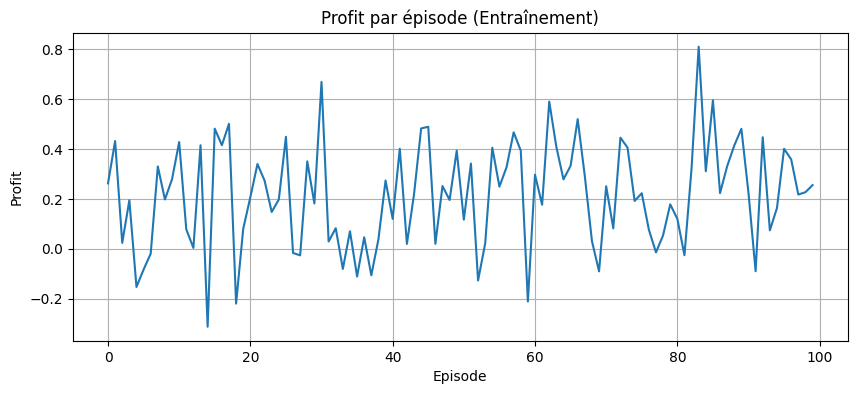

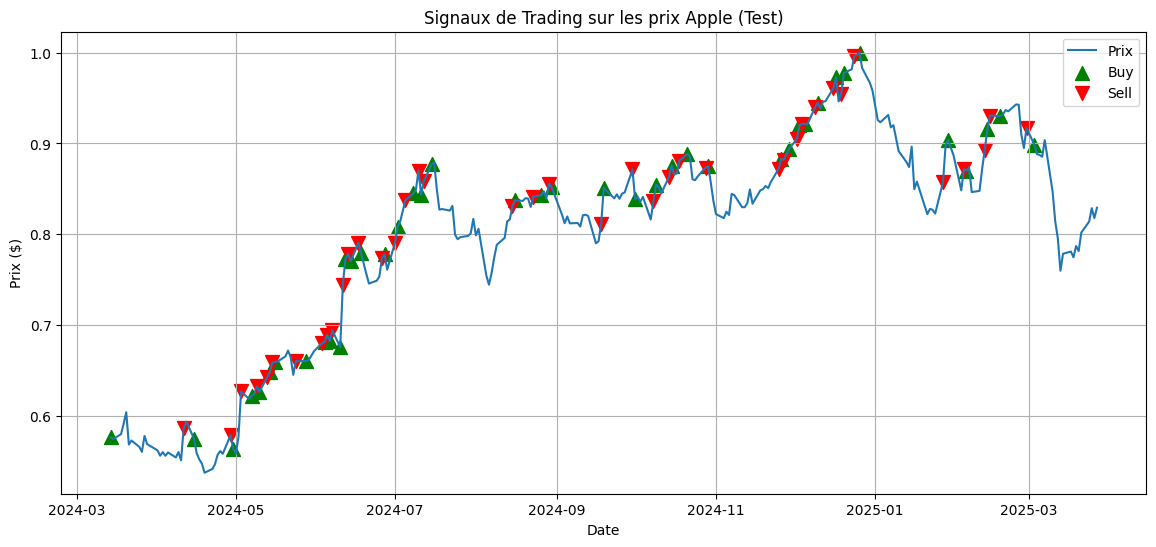

In [14]:
test_env = TradingEnvironment(test_data)
state = test_env.reset()

while True:
    action = np.argmax(agent.get_qs(state))
    next_state, reward, done = test_env.step(action)
    if next_state is not None:
        state = next_state
    if done:
        break

# Metrics
returns = pd.Series(test_env.profits)
cumulative_return = test_env.total_profit
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if len(returns) > 1 else 0
max_drawdown = (np.maximum.accumulate(returns.cumsum()) - returns.cumsum()).max()

print("\n--- Evaluation Finale ---")
print(f"Profit total test: {cumulative_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")

# Courbe d'apprentissage
plt.figure(figsize=(10, 4))
plt.plot(profits)
plt.title("Profit par épisode (Entraînement)")
plt.xlabel("Episode")
plt.ylabel("Profit")
plt.grid()
plt.show()

# Courbe de prix avec signaux d'achat/vente
plt.figure(figsize=(14, 6))
plt.plot(test_data['Date'].values, test_data['Adj Close'].values, label='Prix')

buy_signals = [(idx, price) for idx, action, price in test_env.history if action == 'BUY']
sell_signals = [(idx, price) for idx, action, price in test_env.history if action == 'SELL']

if buy_signals:
    buy_idx, buy_price = zip(*buy_signals)
    plt.scatter(test_data.iloc[list(buy_idx)]['Date'], buy_price, marker='^', color='g', label='Buy', s=100)
if sell_signals:
    sell_idx, sell_price = zip(*sell_signals)
    plt.scatter(test_data.iloc[list(sell_idx)]['Date'], sell_price, marker='v', color='r', label='Sell', s=100)

plt.title("Signaux de Trading sur les prix Apple (Test)")
plt.xlabel("Date")
plt.ylabel("Prix ($)")
plt.legend()
plt.grid()
plt.show()